## Summarization with blurr


In [ ]:
import torch

Using GPU #0: Tesla T4


In [ ]:
# !pip install ohmeow-blurr -q
# !pip install bert-score -q

     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 1.8MB 11.9MB/s 
     |████████████████████████████████| 1.2MB 45.5MB/s 
     |████████████████████████████████| 194kB 57.6MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 7.7MB 51.7MB/s 
     |████████████████████████████████| 4.1MB 53.2MB/s 
     |████████████████████████████████| 163kB 60.5MB/s 
     |████████████████████████████████| 890kB 53.1MB/s 
     |████████████████████████████████| 2.9MB 50.6MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 245kB 65.1MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 


In [ ]:
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

## Loading Model

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'max_length': 142,
 'min_length': 56,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

## Loading Data

In [ ]:
df = pd.read_csv('scrapped_inshorts_0cf8f7c5-7ec3-441d-b275-687702af19e9.csv')

In [ ]:
df.head()

,category,summary,article
0,India,"Nitin Gadkari approves proposal to levy 'Green Tax' on old, polluting vehicles","Union Transport and Highways Minister Nitin Gadkari on Monday approved a proposal to levy 'Green Tax' on old vehicles which are causing pollution. The proposal will now go to the states for consultation, Transport Ministry said. ""Transport vehicles older than eight years could be charged Green Tax at the rate of 10% to 25% of road tax,"" it added."
1,India,"Crorepati's 22-year-old son kills 65-year-old man to pay off ₹30,000 debt; arrested","A 22-year-old man was arrested for allegedly killing a 65-year-old man in Karnataka to pay off ₹30,000 he owed to his friends. Rakesh M, who knew his victim, hit the elderly man with a bat and stabbed him to steal his gold ornaments. Rakesh reportedly belongs to an affluent family and his father owns properties worth crores of rupees."
2,India,"Farmers announce march to Parliament on February 1, Union Budget day","Protesting farmers will march on foot towards the Parliament building from different locations in Delhi on February 1, a leader of the Krantikari Kisan Union said. The Central Government will be presenting the Union Budget for the year 2021-22 on February 1. The farmers' announcement comes a day before their Republic Day tractor rally that will take place in Delhi."
3,India,"India-China talks positive, both agreed on early troop withdrawal from LAC: Army","The Indian Army on Monday said that ninth round of Corps Commander level talks between India and China on the LAC issue were ""positive, practical and constructive"". It said, ""The two sides agreed to push for an early disengagement of frontline troops."" The next round of talks will be held ""at an early date to jointly advance de-escalation"", it added."
4,India,Army's Dhruv helicopter crash lands in J&K's Kathua; 2 pilots seriously injured,"A Dhruv helicopter of the Indian Army crash landed in Lakhanpur area of Jammu and Kashmir's Kathua district on Monday. There were two pilots in the helicopter at the time of the crash, both of whom were grievously injured in the incident. They have been rushed to the Military Base Hospital in Pathankot, police said."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  298 non-null    object
 1   summary   298 non-null    object
 2   article   298 non-null    object
dtypes: object(3)
memory usage: 7.1+ KB


In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('article'), get_y=ColReader('summary'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
len(dls.train.items), len(dls.valid.items)

(239, 59)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 81]), torch.Size([2, 18]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.  We pass in the `dls` via the `dataloaders` argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"Indian audio products brand Mivi has set up its own manufacturing unit in Hyderabad and launched the first Made in India Bluetooth speaker and earphones.""Going Aatmanirbhar and manufacturing locally with the latest technology and premium materials is allowing us to provide affordable and superior products that are better than imported goods and international brands, while also creating employment,"" Mivi said.",Indian Electronics brand Mivi moves manufacturing from China to India
1,"Reliance Jio has started advanced 5G tests in India and is testing transmission speeds using locally-developed equipment. The company said tests on Jio 5G radio integrated with 5G core have delivered throughput in excess of 1 Gbps. ""Jio will continue to accelerate the roll-out of...indigenously developed next-generation 5G stack and make it affordable and available everywhere,"" Mukesh Ambani said.",Reliance Jio begins advanced 5G tests using locally-developed equipment


## Training

In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=6.918309736647643e-06)

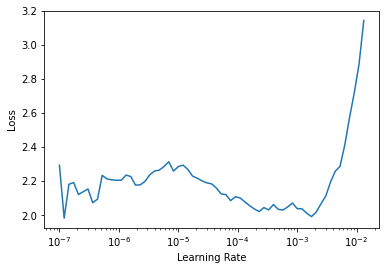

In [ ]:
learn.lr_find(suggestions=True)

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(2.5145, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 16, 50264]))

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.535512,1.527733,0.306883,0.153562,0.252682,0.848429,0.915487,0.880546,01:56


## Inference

In [ ]:
|learn.show_results(learner=learn)

,text,target,prediction
0,"The government has announced seven Padma Vibhushan, 10 Padma Bhushan and 102 Padma Shri Awards for 120 personalities. As many as 29 of the awardees are women. Ex-Japan PM Shinzo Abe, late singer SP Balasubrahmanyam, cardiologist Belle Monappa Hegde, late physicist Narinder Singh Kapany, peace activist Wahiduddin Khan, archaeologist BB Lal and sculptor Sudarshan Sahoo were awarded Padma Vibhushan.","Govt to confer 7 Padma Vibhushan, 10 Padma Bhushan awards this year","As many as 29 of the awardees are women: PM Shinzo Abe, late singer SP Balasubrahmanyam, cardiologist Belle Monappa Hegde, late physicist Narinder Singh Kapany, peace activist Wahiduddin Khan, archaeologist BB Lal among others"
1,"Traders' body CAIT has requested Commerce Minister Piyush Goyal to take strict action against e-commerce entities violating mandatory laws that require them to show country of origin, manufacturer and seller information of the products sold on their platforms. ""It is a pity that...laws and policies are being flouted openly and no department has taken cognisance of compliance issues,"" CAIT wrote.",CAIT seeks strict action against e-comm firms violating country of origin law,"Traders' body CAIT calls on commerce minister to take strict action against e-commerce firms violating laws: CAIT: Laws and policies are being flouted openly, no department has taken cognisance of compliance issues""CAIT: E-commerce platforms must show country of origin, manufacturer, seller information of products sold on platforms"


Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
test_article = """ 
Tesla has claimed that a former engineer, Alex Khatilov, stole more than 6,000 secret files of code to automate business functions during his two-week employment ending January 6. Tesla says it had to sue Khatilov as he lied about his theft and tried to delete its evidence. A US court has ordered him to immediately return all files to Tesla."""

We can override the `text_gen_kwargs` we specified for our `DataLoaders` when we generate text using blurr's `Learner.blurr_generate` method

In [ ]:
actual_headline = "Former engineer stole 6,000 secret files of code just days into the job: Tesla"
actual_headline

'Former engineer stole 6,000 secret files of code just days into the job: Tesla'

In [ ]:
outputs = learn.blurr_generate(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Tesla claims ex-engineer stole 6,000 secret files of code to automate business functions during two-week job .
Tesla says it had to sue Alex Khatilov as he lied about theft and tried to delete evidence: Court orders him to return files immediately

=== Prediction 2 ===
 Tesla claims ex-engineer stole 6,000 secret files of code to automate business functions during two-week job .
Tesla says it had to sue Alex Khatilov as he lied about theft and tried to delete evidence: court orders him to return files

=== Prediction 3 ===
 Tesla claims ex-engineer stole 6,000 secret files of code to automate business functions during two-week job .
Tesla says it had to sue Alex Khatilov as he lied about theft and tried to delete evidence: Court orders him to return files



## Serialization

In [ ]:
learn.metrics = None
learn.export(fname='ft_cnndm_export.pkl')

In [ ]:
inf_learn = load_learner(fname='ft_cnndm_export.pkl')
inf_learn.blurr_generate(test_article)

[' Tesla claims ex-engineer stole 6,000 secret files of code to automate business functions during two-week job .\nTesla says it had to sue Alex Khatilov as he lied about theft and tried to delete evidence: Court orders him to return files immediately']